In [26]:
import numpy as np
import sib_ldsc_z as ld
from scipy.optimize import minimize
from scipy.special import comb
from scipy.misc import derivative
import scipy.stats
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import datetime
import multiprocessing
# import numdifftools as nd
reload(ld)

<module 'sib_ldsc_z' from '/disk/homedirs/nber/harij/gitrepos/SNIPar/ldsc_reg/sib_ldsc_z.py'>

In [10]:
np.random.seed(123)

N = int(1e4)
S = np.array([[[1., 0.5], [-0.5, 1.]]] * N)/N
V = np.array([[0.5, 0.25], [0.25, 0.5]])

model = ld.sibreg(S = S)
model.simdata(V/N, N, simld = True)

Warning there is no value for z. Maybe consider simulating it
No value for U given. Generating a vector of ones (all SNPs weighted equally)
No value for LD Scores given. Generating a vector of ones for l
No value for effective number of loci is given. Using total number of loci instead
Simulated LD scores!


In [3]:
# solving
%time output, result = model.solve()
print(result)

No initial guess provided.
Making Method of Moments Guess
Initial estimate: [1.55430175 1.47910632 0.53409088]
CPU times: user 8.31 s, sys: 58 ms, total: 8.37 s
Wall time: 8.37 s
      fun: 37189.05234762325
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02739723, -0.02879562, -0.00672324])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 11
      nit: 8
   status: 0
  success: True
        x: array([0.51801607, 0.49264674, 0.53215414])


In [95]:
output

{'v1': 0.5180160703428222,
 'v2': 0.49264673706599993,
 'r': 0.5321541425848507,
 'std_err_mat': array([[0.01221355, 0.00124924,        nan],
        [0.00124924, 0.01186258,        nan],
        [       nan,        nan, 0.01696686]])}

In [5]:
%time ld.jkse(model, output, blocksize = 100, num_procs=4)

CPU times: user 47.9 ms, sys: 88.1 ms, total: 136 ms
Wall time: 45.5 s


array([0.0124199 , 0.0115014 , 0.01816286])

In [ ]:
print("Real Parameters:")
print(f"v1 = {V[0, 0]}")
print(f"v2 = {V[1, 1]}")
print(f"r = {V[0, 1]/np.sqrt(V[0, 0] * V[1, 1])}")

In [31]:
# how quick is jkse by N

def getjksetime(N):

    N = int(N)
    S = np.array([[[1., 0.5], [-0.5, 1.]]] * N)/N
    V = np.array([[0.5, 0.25], [0.25, 0.5]])

    model = ld.sibreg(S = S)
    model.simdata(V/N, N, simld = True)

    output, result = model.solve()

    blocksize = int(np.ceil(N/1000))
    startTime = datetime.datetime.now()
    ld.jkse(model, output, blocksize = blocksize, num_procs=6)
    timeexec = datetime.datetime.now() - startTime

    return timeexec.seconds

In [32]:
ngrid = 10
Nrange = np.linspace(1e3, 5e4, ngrid)
timeexec = np.zeros(ngrid)

for idx, N in enumerate(Nrange):
    print(f"==========================")
    print(f"Iteration: {idx}, N: {N}")
    timeexec[idx] = getjksetime(N)


Iteration: 0, N: 1000.0
Warning there is no value for z. Maybe consider simulating it
No value for U given. Generating a vector of ones (all SNPs weighted equally)
No value for LD Scores given. Generating a vector of ones for l
No value for effective number of loci is given. Using total number of loci instead
Simulated LD scores!
No initial guess provided.
Making Method of Moments Guess
Initial estimate: [1.36105486 1.64293983 0.11666446]
Iteration: 1, N: 6444.444444444444
Warning there is no value for z. Maybe consider simulating it
No value for U given. Generating a vector of ones (all SNPs weighted equally)
No value for LD Scores given. Generating a vector of ones for l
No value for effective number of loci is given. Using total number of loci instead
Simulated LD scores!
No initial guess provided.
Making Method of Moments Guess
Initial estimate: [1.38953488 1.7030273  0.17933575]
Iteration: 2, N: 11888.888888888889
Warning there is no value for z. Maybe consider simulating it
No va

KeyboardInterrupt: 

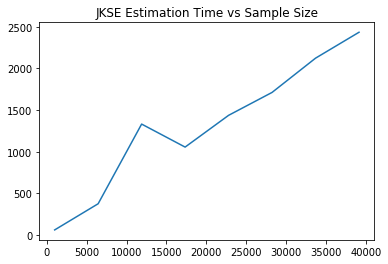

In [33]:
fig, ax = plt.subplots()
ax.plot(Nrange[0:8], timeexec[0:8])
ax.set_title("JKSE Estimation Time vs Sample Size")
plt.show()

In [34]:
# some quick estimations for how long JKSE will take for 1mil snps
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [44]:
x = sm.add_constant(Nrange[0:8])
reg = sm.OLS(endog = timeexec[0:8], exog = x)
result = reg.fit()
hrs = result.predict([1.0, 1000000])/3600
print(f"A dataset with a million observations will take {hrs[0]} hours.")

A dataset with a million observations will take 16.35316110571213 hours.


In [141]:
# Is our hessian calculation corect?
def grad_func(x, z, S, l, M):
    
    return ld._log_ll(x, z, S, l, M)

hess = nd.Hessian(grad_func, method = 'forward', order = 1)

In [147]:
auto_hess = np.zeros((N, 3, 3))
ld_hess = np.zeros((N, 3, 3))

for i in range(N):
    
    auto_hess[i, ...] = hess(ld.Vmat2V(V/N, N), model.z[i, :], model.S[i],  model.l[i], N)
    ld_hess[i, ...] = ld._num_grad2_V(ld.Vmat2V(V/N, N), model.z[i, :], model.S[i],  model.l[i], N)

In [162]:
np.allclose(auto_hess, ld_hess)

False

In [192]:
auto_hess[np.where(~np.isclose(auto_hess, ld_hess))]

array([-0.01496565,  0.00862654, -0.00519013,  0.00073447, -0.00347731,
       -0.00391454, -0.00086705, -0.00121099,  0.00191262,  0.00943349,
       -0.01003163,  0.00586218,  0.00266593,  0.00212742, -0.00518481,
       -0.00357876, -0.00068479, -0.00031514, -0.00090993, -0.00344546,
        0.00294631, -0.00095322, -0.00128309,  0.00224753, -0.01139669,
       -0.016576  , -0.0016433 ,  0.00069306])

In [193]:
ld_hess[np.where(~np.isclose(auto_hess, ld_hess))]

array([-0.01496547,  0.00862669, -0.00518997,  0.00073446, -0.00347724,
       -0.00391443, -0.00086702, -0.00121096,  0.00191266,  0.00943363,
       -0.01003152,  0.00586228,  0.00266601,  0.00212747, -0.00518474,
       -0.00357864, -0.00068477, -0.00031504, -0.00090986, -0.00344541,
        0.00294636, -0.00095318, -0.00128303,  0.00224762, -0.01139657,
       -0.01657573, -0.00164326,  0.0006931 ])

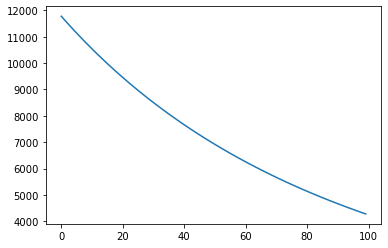

In [189]:
gridsize = 100
v1grid = np.linspace(output_est[0] - 0.1, output_est[0] + 0.1, gridsize)
hessv1 = np.zeros(gridsize)

for i in range(gridsize):
    
    hessv1[i] = ld.get_hessian(np.array([v1grid[i], output_est[1], output_est[2]]),
                           model.z, model.S, model.l, model.u, model.f, model.M)[0, 0]
    
fig, ax = plt.subplots()
ax.plot(hessv1)
plt.show()

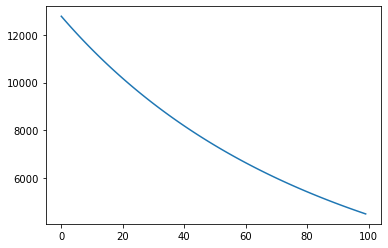

In [190]:
gridsize = 100
v2grid = np.linspace(output_est[1] - 0.1, output_est[1] + 0.1, gridsize)
hessv2 = np.zeros(gridsize)

for i in range(gridsize):
    
    hessv2[i] = ld.get_hessian(np.array([output_est[0], v2grid[i], output_est[2]]),
                           model.z, model.S, model.l, model.u, model.f, model.M)[1, 1]
    
fig, ax = plt.subplots()
ax.plot(hessv2)
plt.show()

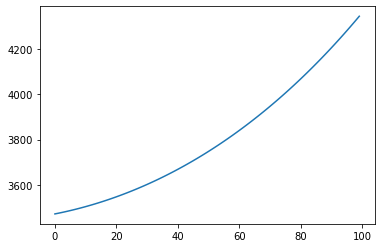

In [191]:
gridsize = 100
rgrid = np.linspace(output_est[2] - 0.1, output_est[2] + 0.1, gridsize)
hessr = np.zeros(gridsize)

for i in range(gridsize):
    
    hessr[i] = ld.get_hessian(np.array([output_est[0], output_est[1], rgrid[i]]),
                           model.z, model.S, model.l, model.u, model.f, model.M)[2, 2]
    
fig, ax = plt.subplots()
ax.plot(hessr)
plt.show()